#Set-up

In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import kagglehub

In [2]:
# ----- Helper Functions for Multi-Spectral Images -----
def open_tif(fn, chnls=None, cls=torch.Tensor):
    im = np.array(Image.open(fn)).astype('float32')
    return cls(im)

def map_filename(base_fn, str1, str2):
    return Path(str(base_fn).replace(str1, str2))

def get_filenames(red_filename):
    return [red_filename,
            map_filename(red_filename, 'red', 'green'),
            map_filename(red_filename, 'red', 'blue'),
            map_filename(red_filename, 'red', 'nir')]

def get_ground_truth(red_filename):
    return map_filename(red_filename, 'red', 'gt')

def open_ms_tif(files):
    ms_img = None
    for path in files:
        img = open_tif(path)
        if ms_img is None:
            ms_img = img[None]  # Add a channel axis.
        else:
            ms_img = np.concatenate([ms_img, img[None]], axis=0)
    return torch.Tensor(ms_img)  # Shape: [4, height, width]

In [3]:
# ----- Download the Dataset -----
dataset_path = kagglehub.dataset_download("sorour/38cloud-cloud-segmentation-in-satellite-images")
print("Dataset downloaded to:", dataset_path)

# ----- Save the Dataset Locally -----
# Define a local directory where the dataset will be saved.
local_save_dir = "local_dataset"
os.makedirs(local_save_dir, exist_ok=True)
# Copy all files from the downloaded dataset directory to the local_save_dir.
# The dirs_exist_ok=True parameter (Python 3.8+) allows merging directories.
shutil.copytree(dataset_path, local_save_dir, dirs_exist_ok=True)
print("Dataset saved locally at:", local_save_dir)

100%|██████████| 12.2G/12.2G [05:11<00:00, 41.9MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images/versions/4
Dataset saved locally at: local_dataset


In [4]:
# ----- Collate the Bands -----
# Use the training folder structure: "38-Cloud_training/train_red", "train_green", "train_blue", "train_nir", etc.
train_red_folder = os.path.join(local_save_dir, "38-Cloud_training", "train_red")
red_files = [os.path.join(train_red_folder, f) for f in os.listdir(train_red_folder) if f.endswith('.TIF')]
if not red_files:
    raise ValueError("No red band .tif files found in the 'train_red' folder.")
selected_red = red_files[1892]
print("Using red band file:", selected_red)

# Get the corresponding band files (green, blue, nir)
band_files = get_filenames(selected_red)
print("Band files:", band_files)

# Open the multispectral image (tensor shape: [4, height, width])
ms_image = open_ms_tif(band_files)
ms_np = ms_image.numpy()

Using red band file: local_dataset/38-Cloud_training/train_red/red_patch_287_14_by_14_LC08_L1TP_045026_20160720_20170221_01_T1.TIF
Band files: ['local_dataset/38-Cloud_training/train_red/red_patch_287_14_by_14_LC08_L1TP_045026_20160720_20170221_01_T1.TIF', PosixPath('local_dataset/38-Cloud_training/train_green/green_patch_287_14_by_14_LC08_L1TP_045026_20160720_20170221_01_T1.TIF'), PosixPath('local_dataset/38-Cloud_training/train_blue/blue_patch_287_14_by_14_LC08_L1TP_045026_20160720_20170221_01_T1.TIF'), PosixPath('local_dataset/38-Cloud_training/train_nir/nir_patch_287_14_by_14_LC08_L1TP_045026_20160720_20170221_01_T1.TIF')]


#Data exploration

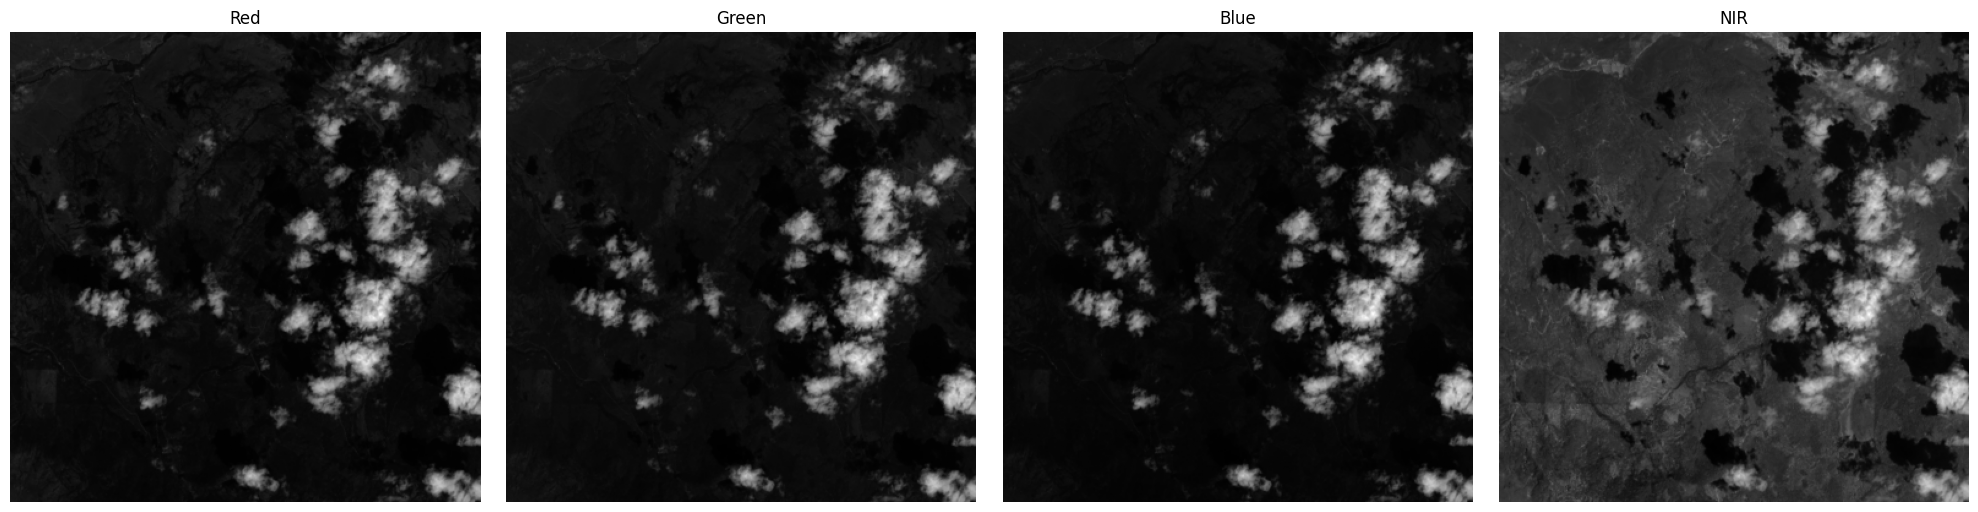

In [5]:
# ----- Display Each Band -----
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
band_names = ['Red', 'Green', 'Blue', 'NIR']

for i in range(4):
    axs[i].imshow(ms_np[i], cmap='gray')
    axs[i].set_title(band_names[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

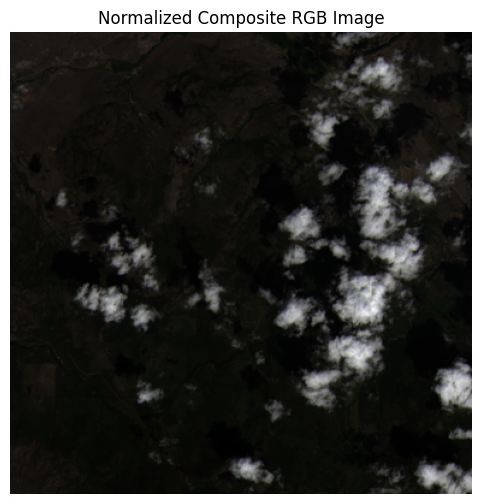

In [6]:
# ----- Optional: Create and Display a Composite RGB Image -----
def normalize_band(band):
    band_min, band_max = band.min(), band.max()
    norm = (band - band_min) / (band_max - band_min) * 255.0
    return norm.astype(np.uint8)

# Normalize red, green, and blue bands
red_norm   = normalize_band(ms_np[0])
green_norm = normalize_band(ms_np[1])
blue_norm  = normalize_band(ms_np[2])
nir_norm   = normalize_band(ms_np[3])

# Stack into an RGB composite
rgb = np.stack([red_norm, green_norm, blue_norm], axis=-1)

# Display the normalized composite image
plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("Normalized Composite RGB Image")
plt.axis('off')
plt.show()

#Otsu's Method

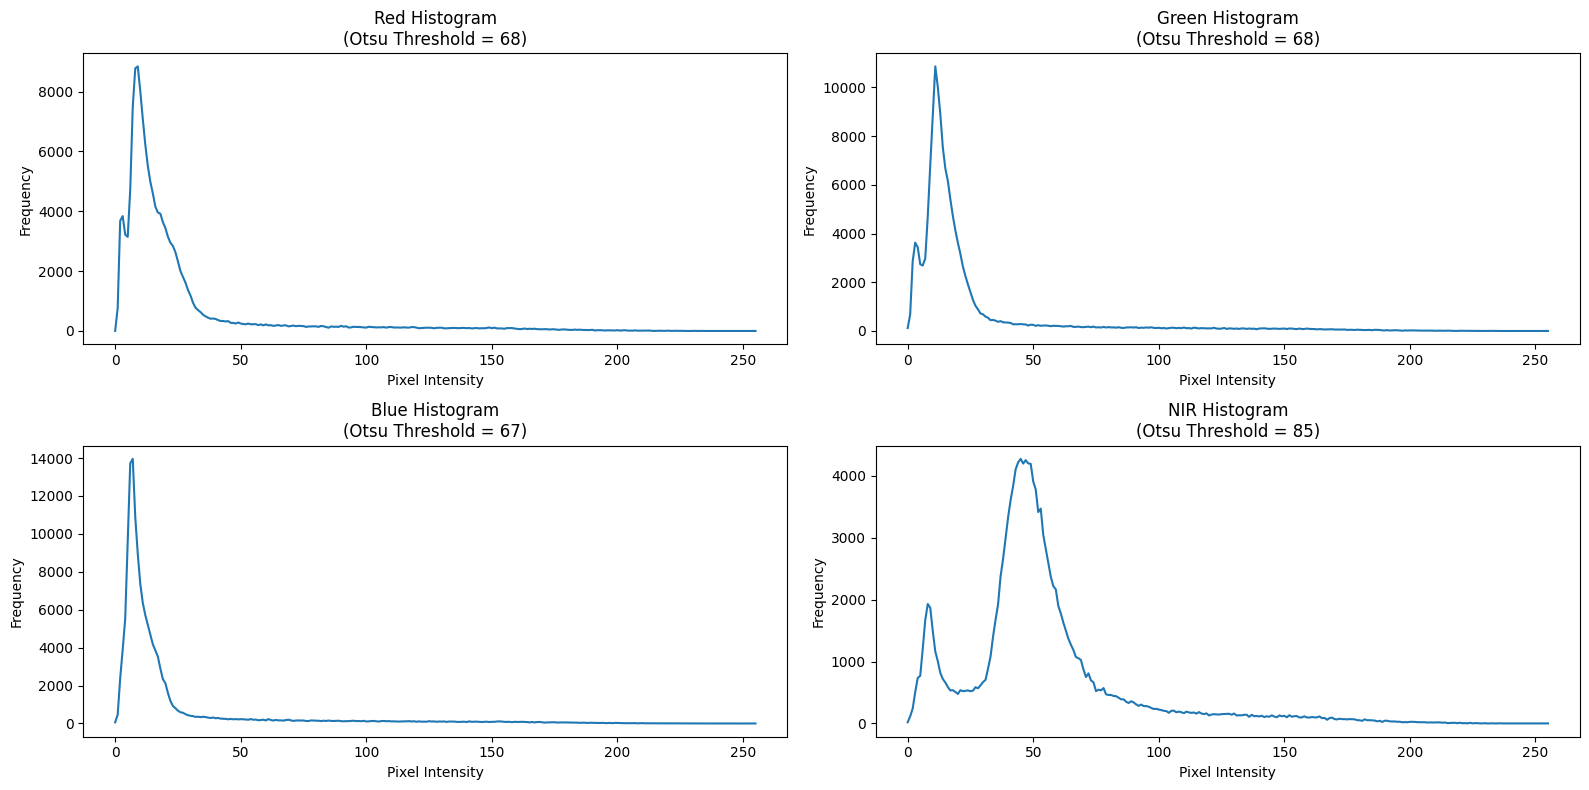

In [7]:
# ----- Compute Per-Band Histograms & Derive Thresholds (Otsu's Method) -----
bands_norm = [red_norm, green_norm, blue_norm, nir_norm]
band_names = ['Red', 'Green', 'Blue', 'NIR']
otsu_thresholds = []
band_masks = []

plt.figure(figsize=(16, 8))
for i, band in enumerate(bands_norm):
    # Compute histogram (for visualization)
    hist, bins = np.histogram(band.ravel(), bins=256, range=[0, 256])

    # Use Otsu's method to compute a threshold automatically.
    ret, mask = cv2.threshold(band, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    otsu_thresholds.append(ret)
    band_masks.append(mask)

    # Plot the histogram
    plt.subplot(2, 2, i+1)
    plt.plot(hist)
    plt.title(f"{band_names[i]} Histogram\n(Otsu Threshold = {ret:.0f})")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

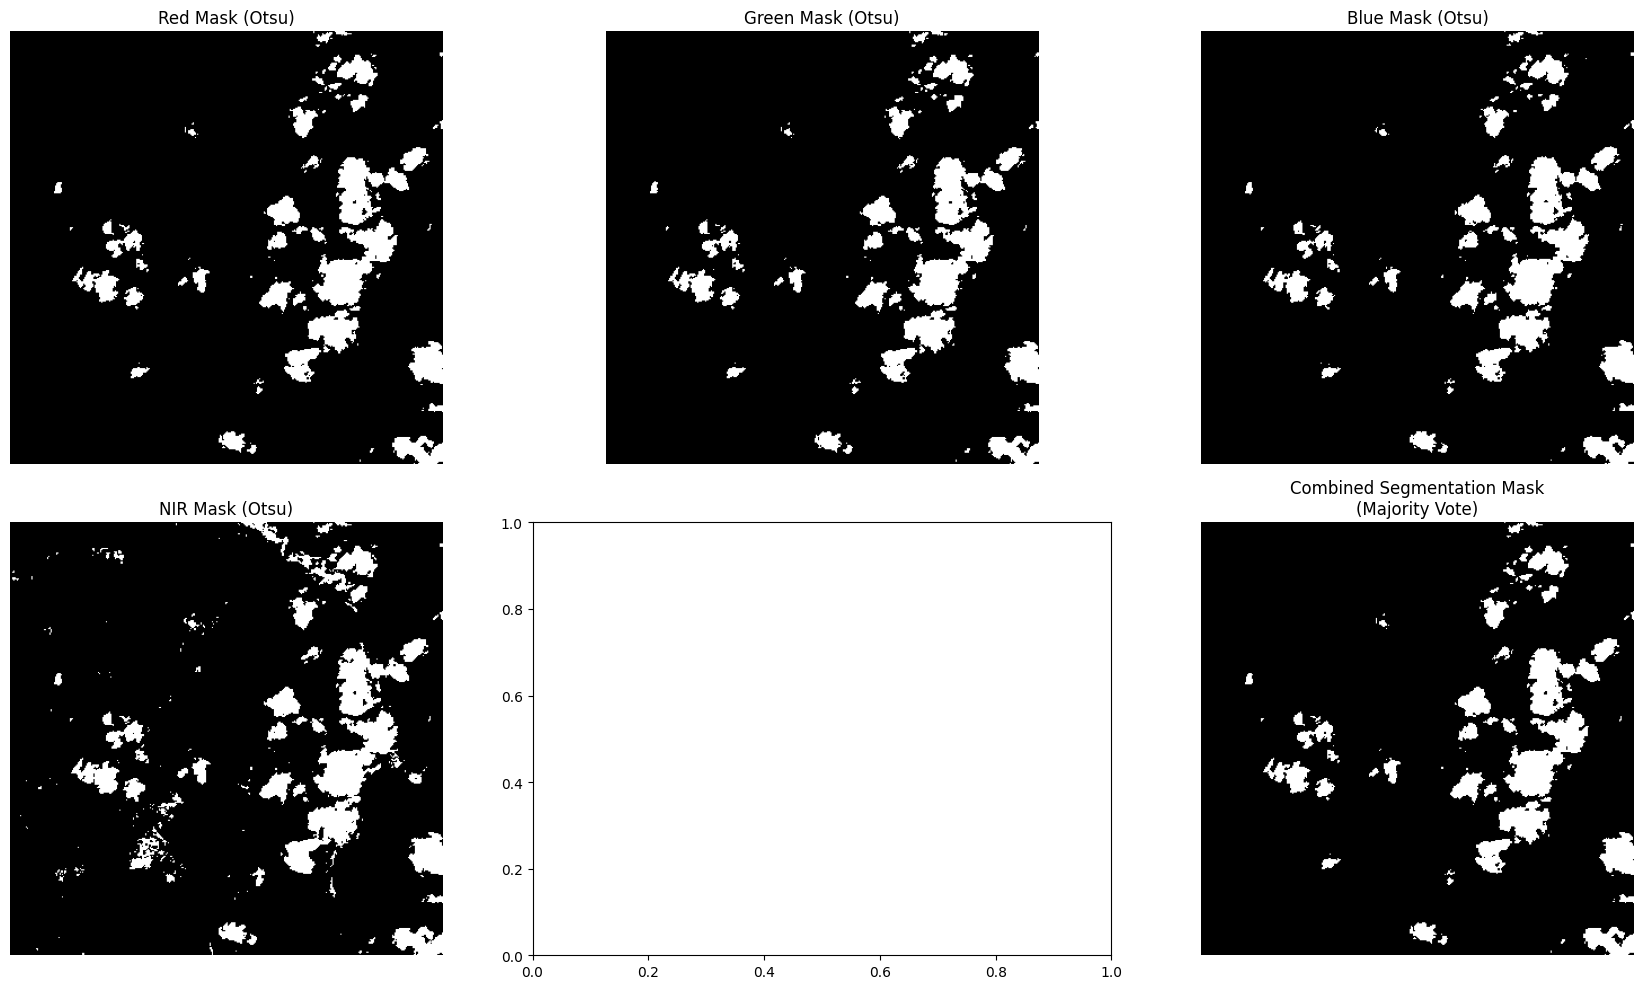

In [8]:
# ----- Combine Masks for Segmentation -----
# We'll use a majority vote rule: a pixel is classified as cloud if it is above its band-specific threshold
# in at least 3 out of 4 bands.
binary_masks = np.stack([mask // 255 for mask in band_masks], axis=0)  # convert masks to 0/1
vote_sum = np.sum(binary_masks, axis=0)
segmentation_mask = np.where(vote_sum >= 3, 255, 0).astype(np.uint8)

# ----- Display the Per-Band Masks and Combined Segmentation Mask -----
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for i, mask in enumerate(band_masks):
    axs[i//3, i%3].imshow(mask, cmap='gray')
    axs[i//3, i%3].set_title(f"{band_names[i]} Mask (Otsu)")
    axs[i//3, i%3].axis('off')
# Show the combined mask in the last subplot.
axs[1, 2].imshow(segmentation_mask, cmap='gray')
axs[1, 2].set_title("Combined Segmentation Mask\n(Majority Vote)")
axs[1, 2].axis('off')
plt.tight_layout()
plt.show()

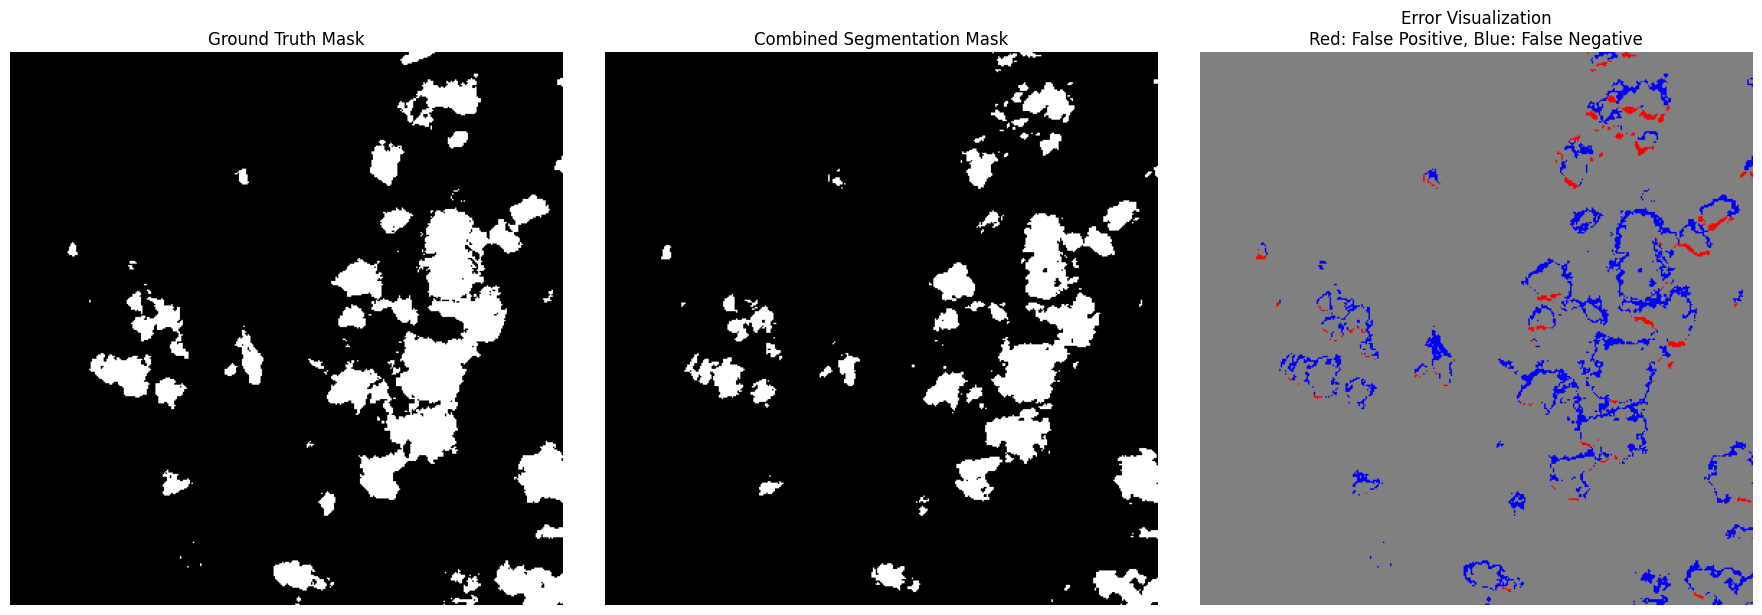

In [9]:
# ----- Display Ground Truth Mask with Colored Errors -----
# Get the ground truth file path and load the ground truth mask.
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

# Compute error masks:
# False Positive (Type I error): predicted cloud but ground truth is non-cloud.
false_positive = np.logical_and(segmentation_mask == 255, ground_truth == 0)
# False Negative (Type II error): predicted non-cloud but ground truth indicates cloud.
false_negative = np.logical_and(segmentation_mask == 0, ground_truth == 255)

# Create an RGB image for the error visualization.
height, width = ground_truth.shape
# Use a neutral gray background for clarity.
error_vis = np.ones((height, width, 3), dtype=np.uint8) * 128

# Overlay errors:
# Mark false positives in red.
error_vis[false_positive] = [255, 0, 0]
# Mark false negatives in blue.
error_vis[false_negative] = [0, 0, 255]

# Display the ground truth, combined segmentation mask, and the colored error visualization.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Ground truth mask.
axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title("Ground Truth Mask")
axs[0].axis('off')

# Combined segmentation mask.
axs[1].imshow(segmentation_mask, cmap='gray')
axs[1].set_title("Combined Segmentation Mask")
axs[1].axis('off')

# Error visualization.
axs[2].imshow(error_vis)
axs[2].set_title("Error Visualization\nRed: False Positive, Blue: False Negative")
axs[2].axis('off')

plt.tight_layout()
plt.show()

#Least Squares

In [ ]:
# ----- Fit Least Squares over Entire Training Dataset -----
# Get list of all red band files in the training dataset.
red_files = [os.path.join(train_red_folder, f) for f in os.listdir(train_red_folder) if f.endswith('.TIF')]
print("Total training images:", len(red_files))

In [11]:
# Initialize lists to accumulate features and targets.
X_list = []
y_list = []

for red_file in red_files:
    # Load multispectral bands.
    band_files = get_filenames(red_file)
    ms_image = open_ms_tif(band_files)  # shape: [4, H, W]
    ms_np = ms_image.numpy()

    # Normalize each band using the provided function.
    red_norm   = normalize_band(ms_np[0])
    green_norm = normalize_band(ms_np[1])
    blue_norm  = normalize_band(ms_np[2])
    nir_norm   = normalize_band(ms_np[3])

    # Stack bands into a feature array (shape: H x W x 4) and flatten to (num_pixels, 4).
    features = np.stack([red_norm, green_norm, blue_norm, nir_norm], axis=-1)
    H, W, _ = features.shape
    features_flat = features.reshape(-1, 4).astype(np.float32) / 255.0  # Scale to [0, 1]

    # Load the corresponding ground truth mask.
    gt_file = get_ground_truth(red_file)
    ground_truth = open_tif(gt_file).numpy().astype(np.uint8)
    # Convert ground truth from 0/255 to binary 0/1.
    ground_truth_bin = (ground_truth > 127).astype(np.float32).flatten()

    X_list.append(features_flat)
    y_list.append(ground_truth_bin)

<ipython-input-6-4c98b40fe1dd>:4: RuntimeWarning: invalid value encountered in divide
  norm = (band - band_min) / (band_max - band_min) * 255.0
<ipython-input-6-4c98b40fe1dd>:5: RuntimeWarning: invalid value encountered in cast
  return norm.astype(np.uint8)


In [ ]:
# Concatenate features and targets from all training images.
X_full = np.concatenate(X_list, axis=0)
y_full = np.concatenate(y_list, axis=0)

# Add a bias term (column of ones) to X_full.
X_full = np.concatenate([np.ones((X_full.shape[0], 1)), X_full], axis=1)

# Compute the optimal weights using the closed-form least squares solution.
weights = np.linalg.lstsq(X_full, y_full, rcond=None)[0]
print("Fitted weights:", weights)

In [ ]:
# ----- Test the Learned Model on a Selected Image -----
# For visualization, we'll use one image from the training set.
selected_red = red_files[1892]  # You can change this index as needed.
band_files = get_filenames(selected_red)
ms_image = open_ms_tif(band_files)
ms_np = ms_image.numpy()
red_norm   = normalize_band(ms_np[0])
green_norm = normalize_band(ms_np[1])
blue_norm  = normalize_band(ms_np[2])
nir_norm   = normalize_band(ms_np[3])

# Prepare the feature array for the selected image.
features = np.stack([red_norm, green_norm, blue_norm, nir_norm], axis=-1)
H, W, _ = features.shape
features_flat = features.reshape(-1, 4).astype(np.float32) / 255.0
X_test = np.concatenate([np.ones((features_flat.shape[0], 1)), features_flat], axis=1)

# Obtain predictions and threshold at 0.5 to create a binary mask.
y_pred = X_test.dot(weights)
segmentation_supervised = (y_pred > 0.5).reshape(H, W).astype(np.uint8) * 255

In [ ]:
# ----- Compute Error Masks for the Supervised Method -----
# Load ground truth mask for the selected image.
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

# False Positives: predicted cloud (255) but ground truth is non-cloud (0).
false_positive_supervised = np.logical_and(segmentation_supervised == 255, ground_truth == 0)
# False Negatives: predicted non-cloud (0) but ground truth indicates cloud (255).
false_negative_supervised = np.logical_and(segmentation_supervised == 0, ground_truth == 255)

# Create an RGB image for error visualization with a neutral gray background.
error_vis_supervised = np.ones((H, W, 3), dtype=np.uint8) * 128
error_vis_supervised[false_positive_supervised] = [255, 0, 0]  # Red for false positives.
error_vis_supervised[false_negative_supervised] = [0, 0, 255]  # Blue for false negatives.

In [ ]:
# ----- Display the Results -----
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Ground Truth Mask.
axs[0].imshow(ground_truth, cmap='gray')
axs[0].set_title("Ground Truth Mask")
axs[0].axis('off')

# Supervised Segmentation Mask.
axs[1].imshow(segmentation_supervised, cmap='gray')
axs[1].set_title("Supervised Segmentation Mask\n(Least Squares)")
axs[1].axis('off')

# Error Visualization.
axs[2].imshow(error_vis_supervised)
axs[2].set_title("Error Visualization\nRed: False Positive, Blue: False Negative")
axs[2].axis('off')

plt.tight_layout()
plt.show()